**Table of contents**<a id='toc0_'></a>    
- 1. [Load data  ](#toc1_)    
- 2. [A few computations ](#toc2_)    
- 3. [Make figure](#toc3_)    
  - 3.1. [Figure for paper](#toc3_1_)    
  - 3.2. [Poster figure](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as path_effects
import matplotlib.patheffects as fx
import matplotlib.patches as mpatches

import sys
sys.path.append('..')
from correlation_measures import correlation_distance, correlation_matrix, cross_corr

# 1. <a id='toc1_'></a>Load data   [&#128285;](#toc0_)

In [2]:
# Load catalogs
# Tremor
trm = pd.read_csv('../data/cascadia/processed/casc_trm_0809_0624.csv', parse_dates=['date'])
day0 = pd.Timestamp('2009-08-01')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

# Earthquakes
eq = pd.read_csv('../data/cascadia/processed/casc_eq_0809_0624.csv')

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

# 2. <a id='toc2_'></a>A few computations  [&#128285;](#toc0_)

In [3]:
# Parameters
xmin_bin = 200
xmax_bin = 1400
dx_bin = 10
x_bin_edges = np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin)


# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 200
xmax_bin = 1400
x_bin_edges = np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin)

# --> Temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

# --> Threshold defining "well-correlated"
cc_thr = 0.07

cc_mat_parameters = dict(dx_bin=dx_bin, xmin_bin=xmin_bin, xmax_bin=xmax_bin, delta=delta, norm=norm, no_bias=no_bias, look_both_ways=look_both_ways, v_min=v_min)

In [4]:
# Compute counts
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

In [5]:
# Compute cross-correlation matrix
cc_matrix, lag_matrix = correlation_matrix(trm, cc_mat_parameters)

In [6]:
# Compute correlation distance
corr_length, left_width, right_width = correlation_distance(cc_matrix, cc_thr, x_bin_edges)

# 3. <a id='toc3_'></a>Make figure [&#128285;](#toc0_)
## 3.1. <a id='toc3_1_'></a>Figure for paper [&#128285;](#toc0_)

In [7]:
# Example of correlation between two bins
x1 = 660  # position along strike (km)
x2 = 750  # position along strike (km)

count1 = counts[np.abs(x_bin_edges[:-1]+dx_bin/2 - x1).argmin()]
count2 = counts[np.abs(x_bin_edges[:-1]+dx_bin/2 - x2).argmin()]
cc12, lag = cross_corr(count1, count2, delta, norm=True, no_bias=True)

t0 = 4260  # in days, start of the count plot
dt = 100  # in days, duration of the plot

count_time = (count_time[1:] + count_time[:-1])/2
count1 = count1[(count_time >= t0) & (count_time < t0 + dt)]
count2 = count2[(count_time >= t0) & (count_time < t0 + dt)]
count_time = count_time[(count_time >= t0) & (count_time < t0 + dt)]

cc12 = cc12[(lag >= -1.5*(x2-x1)/v_min) & (lag <= 1.5*(x2-x1)/v_min)]
lag = lag[(lag >= -1.5*(x2-x1)/v_min) & (lag <= 1.5*(x2-x1)/v_min)]

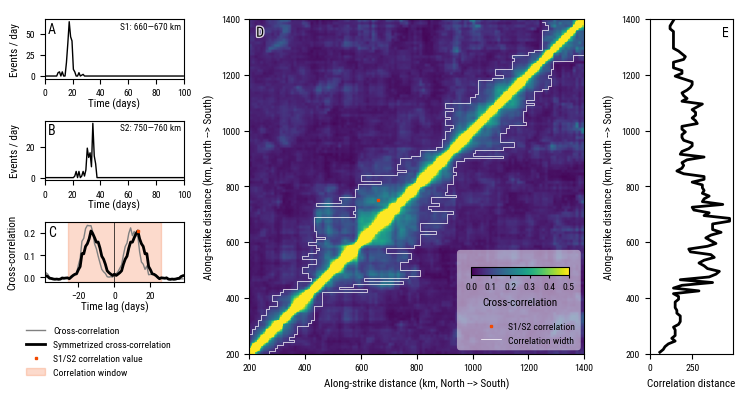

In [14]:
# Plot
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 10])/2.54)
    gs = fig.add_gridspec(4, 4, width_ratios=[1, 1, 1, .6], height_ratios=[1, 1, 1, .5])

    # Time series
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

    for ax in [ax1, ax2]:
        ax.set_ylabel('Events / day')
        ax.set_xlabel('Time (days)', labelpad=0)
        ax.set_xticks(np.arange(0, 6/5*dt, dt/5))
        ax.set_xlim(0, dt)
    ax1.plot(count_time-t0, count1, 'k-', lw=1)
    ax2.plot(count_time-t0, count2, 'k-', lw=1)

    ax1.text(.98, .95, 'S1: {:.0f}—{:.0f} km'.format(x1, x1+dx_bin), transform=ax1.transAxes, fontsize='small', va='top', ha='right')
    ax2.text(.98, .95, 'S2: {:.0f}—{:.0f} km'.format(x2, x2+dx_bin), transform=ax2.transAxes, fontsize='small', va='top', ha='right')

    ax1.text(.02, .95, 'A', transform=ax1.transAxes, fontsize=10, va='top', ha='left')
    ax2.text(.02, .95, 'B', transform=ax2.transAxes, fontsize=10, va='top', ha='left')

    # Autocorrelation function
    ax = fig.add_subplot(gs[2, 0])
    ax.set_xlabel('Time lag (days)', labelpad=0)
    ax.set_ylabel('Cross-correlation')

    ax.plot(lag, cc12, ls='-', c='.5', lw=1, label='Cross-correlation')
    ax.plot(lag, (cc12 + cc12[::-1])/2, ls='-', c='k', lw=2, label='Symmetrized cross-correlation')

    in_window = (lag > 0) & (lag < (x2-x1)/v_min)
    ii_max = np.argmax(((cc12 + cc12[::-1])/2)[in_window])
    ax.plot(lag[in_window][ii_max], ((cc12 + cc12[::-1])/2)[in_window][ii_max], 's', c='C1', ms=2, label='S1/S2 correlation value')

    ax.axvspan(-(x2-x1)/v_min, (x2-x1)/v_min, color=to_rgba('C1', .2), zorder=-10, label='Correlation window')
    ax.axvline(0, color='k', lw=.5)

    ax.set_xlim(-1.5*(x2-x1)/v_min, 1.5*(x2-x1)/v_min)
    ax.set_ylim(-0.02, 0.25)

    ax.legend(bbox_to_anchor=(-0.2, -0.6), loc='upper left', framealpha=0, )

    ax.text(.02, .95, 'C', transform=ax.transAxes, fontsize=10, va='top', ha='left')

    # Matrix
    ax = fig.add_subplot(gs[:, 1:-1])
    ax.set_aspect('equal')
    ax.set_xlabel('Along-strike distance (km, North --> South)')
    ax.set_ylabel('Along-strike distance (km, North --> South)')

    im = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=.5, origin='lower')
    ax.plot(x1, x2, 's', c='C1', ms=2, label='S1/S2 correlation')
    ax.step(x_bin_edges[:-1]-left_width, x_bin_edges[:-1], c='w', lw=.5)
    ax.step(x_bin_edges[:-1]+right_width+dx_bin, x_bin_edges[:-1], c='w', lw=.5, label='Correlation width')

    leg = ax.legend(bbox_to_anchor=(1, 0), loc='lower right', framealpha=0)

    cb_ax = plt.axes([0.63, 0.30, 0.13, 0.02])
    cbar = plt.colorbar(im, cax=cb_ax, orientation='horizontal', label='Cross-correlation')
    cb_ax.set_xticks([0, .1, .2, .3, .4, .5])
    cb_ax.tick_params(length=2)

    box = mpatches.FancyBboxPatch([.62, .01], .37, .30, boxstyle="Round, pad=0, rounding_size=.01", facecolor=to_rgba('w', .5), edgecolor=[0,0,0,0], transform=ax.transAxes)
    ax.add_patch(box)

    ax.text(.02, .98, 'D', transform=ax.transAxes, fontsize=10, va='top', ha='left', path_effects=[fx.withStroke(linewidth=2, foreground=to_rgba('w', .8))])

    # Correlation distance
    ax = fig.add_subplot(gs[:, -1], sharey=ax)
    ax.set_xlabel('Correlation distance')
    ax.set_ylabel('Along-strike distance (km, North --> South)')

    ax.plot(corr_length, x_bin_edges[:-1]+dx_bin/2, 'k-', lw=2)

    ax.set_xlim(xmin=0)

    ax.text(.95, .98, 'E', transform=ax.transAxes, fontsize=10, va='top', ha='right', path_effects=[fx.withStroke(linewidth=2, foreground=to_rgba('w', .8))])

    plt.subplots_adjust(left=.06, right=.98, top=.95, bottom=.1, wspace=.5, hspace=.8)
    plt.savefig('../figures/correlation_distance.pdf', dpi=400)
    plt.savefig('../figures/correlation_distance.png', dpi=400)
    plt.show()

## 3.2. <a id='toc3_2_'></a>Poster figure [&#128285;](#toc0_)

In [9]:
# # Same figure but for poster
# with plt.style.context('grl'):
#     fig = plt.figure(figsize=np.array([12, 6])/2.54)
#     gs = fig.add_gridspec(3, 3, width_ratios=[.5, 1, 1], height_ratios=[.8, 1, .8])

#     # Time series
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)

#     for ax in [ax1, ax2]:
#         ax.set_ylabel('Events / day', labelpad=0)
#         ax.set_xlabel('Time (days)', labelpad=0)
#         ax.set_xticks(np.arange(0, 5/4*dt, dt/4))
#         ax.set_xlim(0, dt)
#     ax1.plot(count_time-t0, count1, 'k-', lw=1)
#     ax2.plot(count_time-t0, count2, 'k-', lw=1)

#     ax1.text(0, 1.02, 'S1: {:.0f}—{:.0f} km'.format(x1, x1+dx_bin), transform=ax1.transAxes, fontsize='small', va='bottom', ha='left', clip_on=False)
#     ax2.text(0, 1.02, 'S2: {:.0f}—{:.0f} km'.format(x2, x2+dx_bin), transform=ax2.transAxes, fontsize='small', va='bottom', ha='left', clip_on=False)

#     # Matrix
#     ax = fig.add_subplot(gs[:, 1:])
#     ax.set_aspect('equal')
#     ax.set_xlabel('Along-strike distance (km, North --> South)', labelpad=0)
#     ax.set_ylabel('Along-strike distance (km, North --> South)', labelpad=0)

#     im = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
#     ax.plot(x1, x2, 's', c='C1', ms=2, label='S1/S2 correlation')
#     ax.step(x_bin_edges[:-1]-left_width, x_bin_edges[:-1], c='w', lw=.5)
#     ax.step(x_bin_edges[:-1]+right_width+dx_bin, x_bin_edges[:-1], c='w', lw=.5, label='Correlation width')

#     leg = ax.legend(bbox_to_anchor=(1, 0), loc='lower right', fontsize='x-small', handlelength=1, handletextpad=.5, framealpha=.5)

#     cb_ax = plt.axes([0.688, 0.39, 0.11, 0.02])
#     cbar = plt.colorbar(im, cax=cb_ax, orientation='horizontal')
#     cbar.set_label(size='x-small', label='Cross-correlation', labelpad=0)
#     cb_ax.tick_params(axis='both', which='both', labelsize='x-small', pad=1, length=2)

#     box = mpatches.FancyBboxPatch([.62, .19], .37, .15, boxstyle="Round, pad=0, rounding_size=.01", facecolor=to_rgba('w', .5), edgecolor=to_rgba('w', .5), transform=ax.transAxes)
#     ax.add_patch(box)

#     plt.subplots_adjust(left=.08, right=.98, top=.95, bottom=.15, wspace=0, hspace=0)
#     # plt.savefig('../figures/correlation_distance_small.pdf', dpi=300)
#     # plt.savefig('../figures/correlation_distance_small.png', dpi=300)
#     plt.show()